In [ ]:
%matplotlib notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "syllables_fourier", "std_phon_trace", "traces_fourier", "spectral_centroid", "spectral_mode"]
INTERESTING_TRACES += [f"syllables_{i}_ts" for i in range(7)]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")
# matplotlib.rcParams['figure.figsize'] = (10, 5)

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import default_style

font sizes set


## Import

In [2]:
df = pd.read_csv(DF_PREPROC_FILE)
df.drop(columns=["fourier_coeffs", "path", "filtered_fourier_coeffs"], inplace=True)

categorical_attributes = [col for col in df.columns if not is_numeric_dtype(df[col])]


traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)

print(traces["syll_labels"].shape)

(17164,)


## Metrics

In [4]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [5]:
mat_euclidean = cdist(traces["traces_fourier"],traces["traces_fourier"])

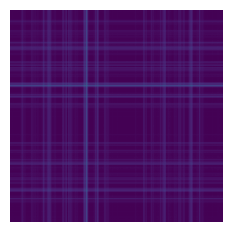

In [6]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

Text(0.5, 0, 'Euclidean distance')

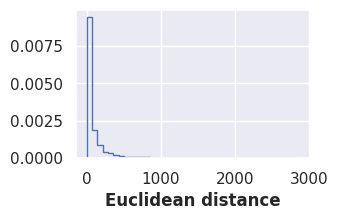

In [83]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);
plt.xlabel("Euclidean distance")

### Manhattan

In [7]:
mat_manhattan = cdist(traces["traces_fourier"],traces["traces_fourier"], metric="cityblock")

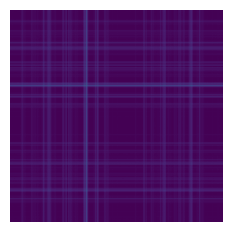

In [14]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

NameError: name 'mat_manhattan' is not defined

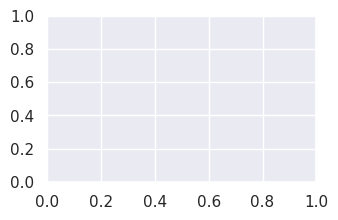

In [82]:
# Distribution of distances
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'AttributeError(module 'numba' has no attribute 'extending')'.
  entrypoints.init_all()


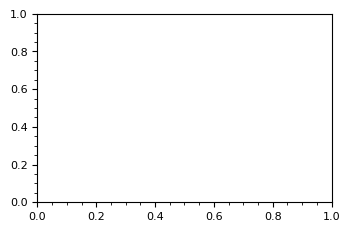

In [16]:
from tslearn.metrics import cdist_dtw
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

mat_dtw = cdist_dtw(traces["std_phon_trace"][:10],traces["std_phon_trace"][:10], itakura_max_slope=2, n_jobs=-1)

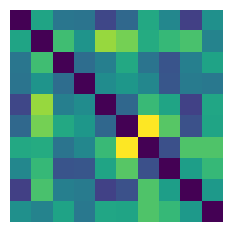

In [17]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Test: KNN search

In [9]:
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.model_selection import train_test_split

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


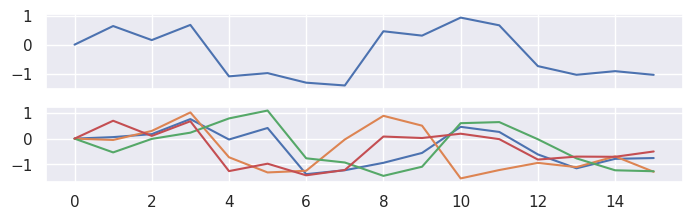

In [12]:
X_train, X_test = train_test_split(traces["traces_fourier"], test_size=0.1)

knn = KNeighborsTimeSeries(n_neighbors=4)
knn.fit(X_train)

# Find nearest neighbours of a query trace
query_trace = 1
nearest = knn.kneighbors([X_test[query_trace]], return_distance=False)[0]

fig, (axquery, axnearest) = plt.subplots(2,1, sharex=True, figsize=default_style.SHORT_FULLSIZE_FIGURE)
axquery.plot(X_test[query_trace])

# Plot the most similar results
for idx in nearest:
    axnearest.plot(X_train[idx])

In [ ]:
X_train.shape

## Kmeans

### Spectral timeseries (Euclidean)

In [4]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KernelKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score as ami

In [5]:
X = np.stack(traces["spectral_centroid"])
print(traces["spectral_centroid"].shape)
print(X.shape)

(2452, 54)
(2452, 54)


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.026408424595742604, 0.028974779936964234, 0.03138132828490071, 0.0027448083499603208, -0.000131033050073484, 0.11559993485757263, 0.24590526953751346]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.021986815406877924, 0.05391053202988352, 0.038815823057262874, 0.0009963594265193737, -0.0003723550178126528, 0.11880059721457457, 0.19663729515496706]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.01882366295165257, 0.058410787658270506, 0.028690468767895223, 0.1789155185822669, -0.0004446229792800304, 0.10560588019885855, 0.15308790525525173]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.055786421408011065, 0.05197646811510366, 0.023429259132726636, 0.1330091333146366, -0.0006288686068601391, 0.11419383146563525, 0.15063039946787204]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.06641056330904438, 0.0552986237918312, 0.022667884284021868, 0.11687006974170305, -0.0006381189403759225, 0.1483809716487115, 0.18362306154115698]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.04219057685011663, 0.0606039099588795, 0.02191777754054995, 0.16741417486592292, -0.0007055667704526946, 0.12914073053372782, 0.1391073926766149]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08084524250688996, 0.05368326625227945, 0.020897974511580306, 0.15342260909277233, -0.000873666444370861, 0.13847049041733775, 0.15139057852860738]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08114417017003427, 0.05602610434691989, 0.019243961255510866, 0.14610941805498703, -0.0008213849174822054, 0.15285509388507754, 0.15186129484368002]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08130756334385346, 0.05745304077122028, 0.024578960699691402, 0.1433731774734991, -0.00038164551050036004, 0.1498074232156346, 0.15296234432040537]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08866165180380013, 0.06245444403600876, 0.025179562480005652, 0.1260794764953082, -0.0009158912252888266, 0.15748776190547287, 0.14819857093963948]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08258541765268052, 0.060075746420752335, 0.02063805019817811, 0.16012623731079245, -0.0005948207254346636, 0.14933203836500616, 0.13847221293929576]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08614089980362163, 0.06485530483918582, 0.01982442450607866, 0.17109944531033985, -0.0009828319993637757, 0.1543144556876245, 0.1381996550140867]



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.06951681944534371, 0.06022191005880736, 0.02249735991131322, 0.1586674517957457, -0.0010107992825268354, 0.1527341464227149, 0.13824368790407737]



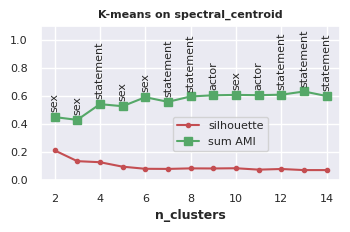

In [144]:
fig, ax= plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

sil_scores = []
amis = []
ns_clust = np.arange(2, 15)

for n in ns_clust:
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", n_jobs=-1)
    km.fit(X)
    predictions = km.predict(X)
    sil_scores.append(silhouette_score(X, predictions, metric="euclidean", n_jobs=-1))
    
    ami_list = [ami(predictions, df[cat]) for cat in categorical_attributes]
    print(categorical_attributes)
    print(ami_list)
    print()
    amis.append(np.sum(ami_list))
    ax.annotate(f"{categorical_attributes[np.argmax(ami_list)]}",xy=(n, amis[-1]+0.05), ha="center", rotation=90, size=8)
    
ax.plot(ns_clust, sil_scores, label="silhouette", marker=".", color="r")
ax.plot(ns_clust, amis, label="sum AMI", marker="s", color="g")
ax.set_title('K-means on spectral_centroid')
ax.set_xlabel('n_clusters')
ax.set_ylim(0, 1.1)
ax.legend(loc="center", bbox_to_anchor=(0.6, 0.3))
fig.savefig("../images/ts_cluster_ami_sil.pdf")

In [146]:
n_clusters = 6

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      verbose=False, 
                      n_jobs=-1)
km.fit_predict(X)

# fig, axes = plt.subplots(n_clusters,1,sharex=True, figsize=default_style.SHORT_FULLSIZE_FIGURE)

# for clus in range(n_clusters):
#     cluster_elements = X[km.labels_ == clus]
#     for i in range(5):
#         axes[clus].plot(cluster_elements[i], alpha=0.4, color="k")
#     axes[clus].set_yticks([])
#     axes[clus].plot(km.cluster_centers_[clus])
    
# df_ami = pd.DataFrame(columns=categorical_attributes)
# for cat in categorical_attributes:
#     print(cat, ami(km.labels_, df[cat]))
# plt.savefig("../images/ts_classification.pdf")

array([1, 1, 5, ..., 3, 3, 3])

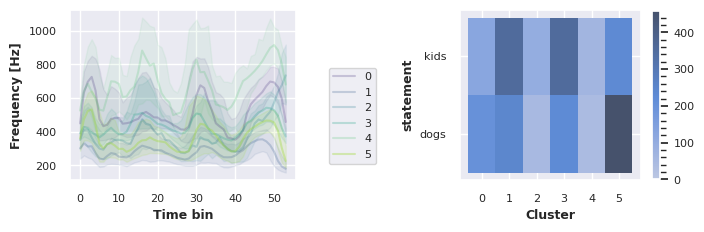

In [147]:
category = "statement"

fig, axes = plt.subplot_mosaic([["t", "leg", "hist"]], 
                              width_ratios=[1, 0.1, 1],  
                              figsize=default_style.SHORT_FULLSIZE_FIGURE)

colors=sns.color_palette("viridis", n_colors=n_clusters)

for i in range(n_clusters):
    cluster_traces = np.where(km.labels_ == i)[0]
    
    alpha = min(5*np.abs(ami(km.labels_ == i, df[category])) + 0.2, 1)
    
    low, mid, up = np.quantile(X[cluster_traces], [0.25, 0.5, 0.75], axis=0)
    axes["t"].plot(mid, color=colors[i], label=f"{i}", alpha=alpha)
    axes["t"].fill_between(np.arange(X.shape[1]),low, up, alpha=alpha/3, color=colors[i])

sns.histplot(x=km.labels_.astype(int),bins=( list(np.arange(n_clusters+1) -0.01) ), 
             y=df[category],
             cbar=True, cbar_kws=dict(shrink=.99))
axes["hist"].set_xticks(np.arange(n_clusters)+0.5, labels=range(n_clusters));

axes["t"].set_ylabel("Frequency [Hz]");
axes["t"].set_xlabel("Time bin")
fig.legend(loc="center", title="")

axes["hist"].set_xlabel("Cluster")

axes["leg"].axis("off")

fig.savefig("../images/ts_cluster_counts.pdf")

In [140]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

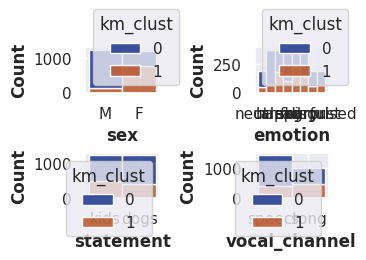

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

### Spectral timeseries (DTW)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2452 out of 2452 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=

857142.854 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.2s finished


525788.500 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


518032.129 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


517045.674 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


516849.181 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.2s finished


516526.777 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.6s finished


516384.630 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.6s finished


516342.051 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.2s finished


516340.761 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


516340.761 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.3s finished


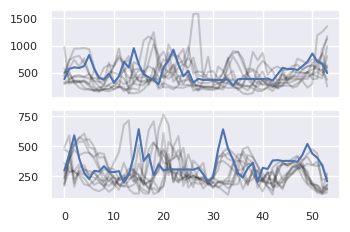

In [47]:
n_clusters = 2

# Fit and save
km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=True)

km.fit_predict(X)
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

km = TimeSeriesKMeans.from_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X[km.labels_ == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].plot(km.cluster_centers_[clus])

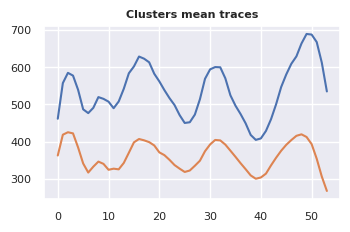

In [49]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
    plt.title('Clusters mean traces')
plt.show()

In [ ]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

## Approximated Clustering std_phon

In [50]:
from pyts.approximation import DiscreteFourierTransform
from tslearn.piecewise import PiecewiseAggregateApproximation

In [51]:
X = np.stack(traces["std_phon_trace"])

n_paa_segments = 30
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


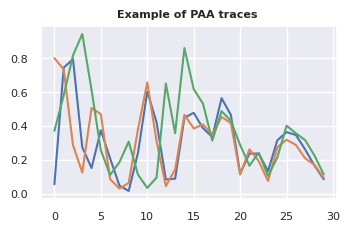

In [52]:
plt.plot(X_paa[0])
plt.plot(X_paa[1])
plt.plot(X_paa[2])
plt.title('Example of PAA traces ')
plt.show()

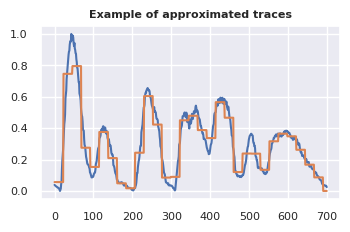

In [53]:
plt.plot(traces['std_phon_trace'][0])
plt.plot(paa.inverse_transform(X_paa)[0])
plt.title('Example of approximated traces')
plt.show()

In [54]:
sil_scores = []
for n in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean")
    km.fit(X_paa)
    sil_scores.append(silhouette_score(X_paa, km.predict(X_paa), metric="euclidean"))
    

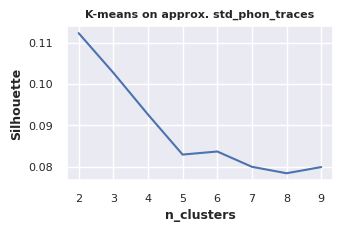

In [55]:
plt.plot(range(2, 10),sil_scores)
plt.title('K-means on approx. std_phon_traces')
plt.ylabel('Silhouette')
plt.xlabel('n_clusters')
plt.show()

2.297 --> 1.378 --> 1.368 --> 1.362 --> 1.351 --> 1.339 --> 1.326 --> 1.317 --> 1.311 --> 1.308 --> 1.306 --> 1.305 --> 1.304 --> 1.303 --> 1.303 --> 1.303 --> 1.303 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 1.302 --> 


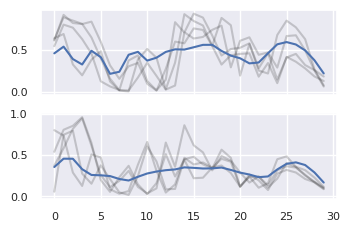

In [56]:
n_clusters = 2

# np.random.shuffle(X_train)
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, metric='euclidean', n_jobs=-1)#or dtw
km.fit_predict(X_paa)

fig, axes = plt.subplots(n_clusters,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_paa[km.labels_ == clus]
    for i in range(4):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])
plt.show()

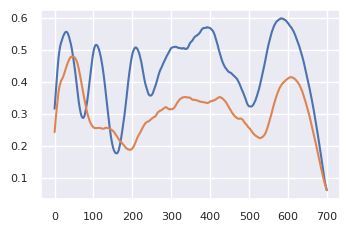

In [57]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

In [58]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

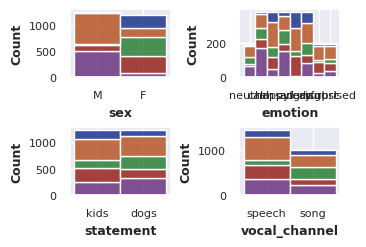

In [120]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j], legend=False)
        j=j+1
plt.show()

## Features clustering on spectral timeseries

In [60]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

In [61]:
X = traces['spectral_centroid']


In [62]:
def calculate_features(values):
    peaks = find_peaks(values, distance=3, prominence=[0.20,10])
    features = {
        'peaks':len(peaks[0]),
        'min': np.min(values),
        'max': np.max(values),
        'avg': np.mean(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
    }

    return features

In [63]:
F = [list(calculate_features(x).values()) for x in X]

In [64]:
from sklearn.metrics import silhouette_score
sil_scores = []
for n in range(2, 20):
    km = KMeans(n_clusters=n)
    km.fit(F)
    sil_scores.append(silhouette_score(F, km.predict(F)))
    

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

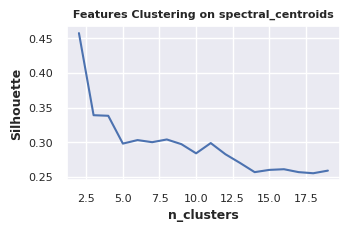

In [65]:
plt.plot(range(2, 20),sil_scores)
plt.title(' Features Clustering on spectral_centroids ')
plt.ylabel('Silhouette')
plt.xlabel('n_clusters')
plt.show()

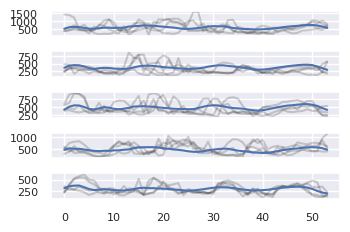

In [66]:
n_clusters = 5


km = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100)
km.fit(F)

fig, axes = plt.subplots(n_clusters,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X[km.labels_ == clus]
    for i in range(4):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(np.mean(X[np.where(km.labels_ == clus)[0]], axis=0))
    
plt.show()

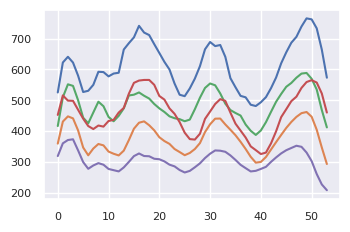

In [67]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

In [68]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

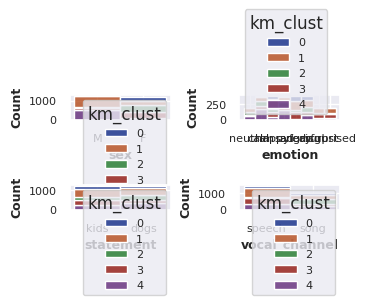

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

# Clustering visualization

## PCA

In [70]:
from sklearn.decomposition import PCA

In [71]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

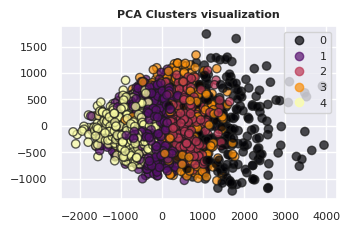

In [72]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='inferno', edgecolor='k'
             , alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)))
plt.title('PCA Clusters visualization')
plt.show()

## MultiDim Scaling

In [ ]:
from sklearn.manifold import Isomap

In [ ]:
iso = Isomap(n_components=2)
X_iso = iso.fit_transform(X)

In [ ]:
scatter = plt.scatter(X_iso[:, 0], X_iso[:, 1], c=km.labels_, cmap='inferno', edgecolor='k',alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)))
plt.title('IsoMap Clusters visualization')
plt.show()